## 银行信用预测

### 相关包引入

In [1]:
# 引入第三方库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 引入数据分析库
from DataSet_tools.data_processing import PreProcessing
from DataSet_tools.data_split import train_test_split, cross_validation
from DataSet_tools.score import accuracy, ROC, PR, F1score
# 引入逻辑回归模型
from LogisticRegression.LR import LogisticRegression
# 引入k近邻模型
from K_nearestNeighbors.Classification import KNN
# 引入决策树模型
from DecisionTree.classfication import DecisionTree

%matplotlib inline

### 数据读取， 设置绘图风格， 引入数据预处理库

In [2]:
plt.style.use('seaborn')
data = pd.read_csv('Data/GiveMeSomeCredit/cs-training.csv')
pp = PreProcessing()

### 数据展示

In [3]:
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### 删去编号列后，检测缺失值

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)
data.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

### 因为缺失值较多，且不缺乏训练数据，所以删除全部缺失值所在行

In [5]:
data = data.dropna(axis=0)

### 判断是否还有缺失值

In [6]:
data.isnull().sum().sum()

0

### 将分类结果放到最后一列

In [7]:
y = data['SeriousDlqin2yrs']
x = data.drop(['SeriousDlqin2yrs'], axis=1)
data = pd.concat([x, y], axis=1)

### 用箱线图查看异常值

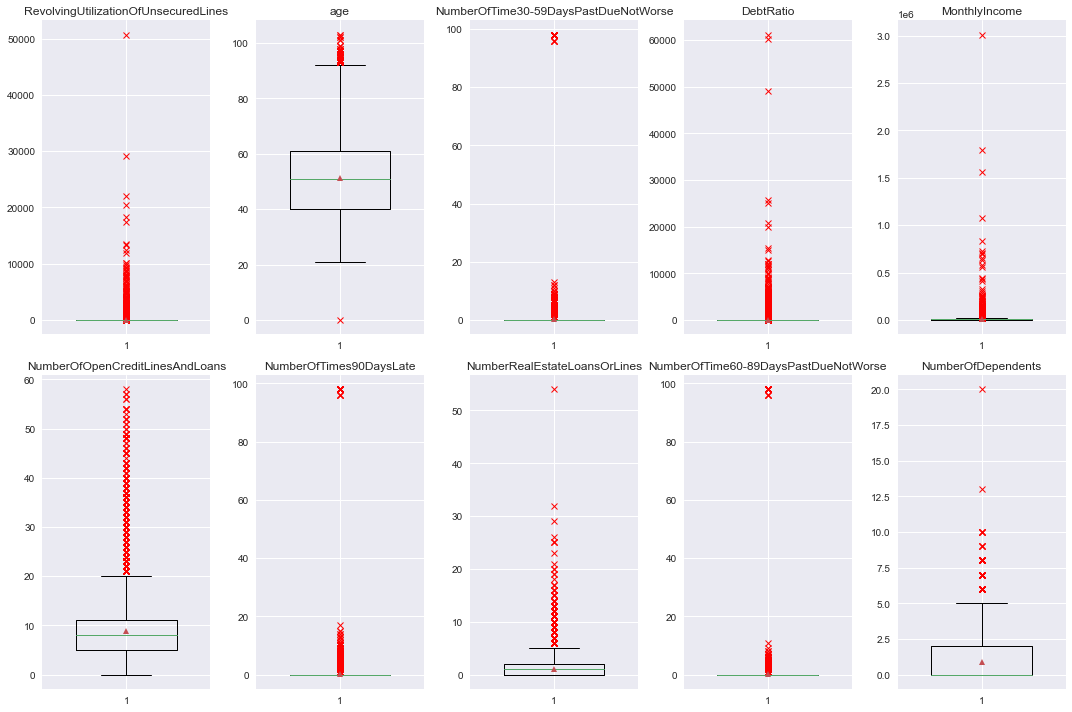

In [8]:
index = data.columns
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.boxplot(data[index[i]], sym='rx', widths=0.6, showmeans=True)
    ax.set_title(index[i])
fig.tight_layout()

### 有几个特征0值占比过大，导致数据清理后会只剩0，这里选择进行手动清理

In [9]:
# 处理其他列的缺失值
data = pp.Clean(data, column=[2, 6, 8, 10])
# 手动清理
new = data.iloc[:, 2].copy()
new[new > 40] = 0
data.iloc[:, 2] = new
new = data.iloc[:, 6].copy()
new[new > 40] = 0
data.iloc[:, 6] = new
new = data.iloc[:, 8].copy()
new[new > 40] = 0
data.iloc[:, 8] = new

### 再次查看箱线图

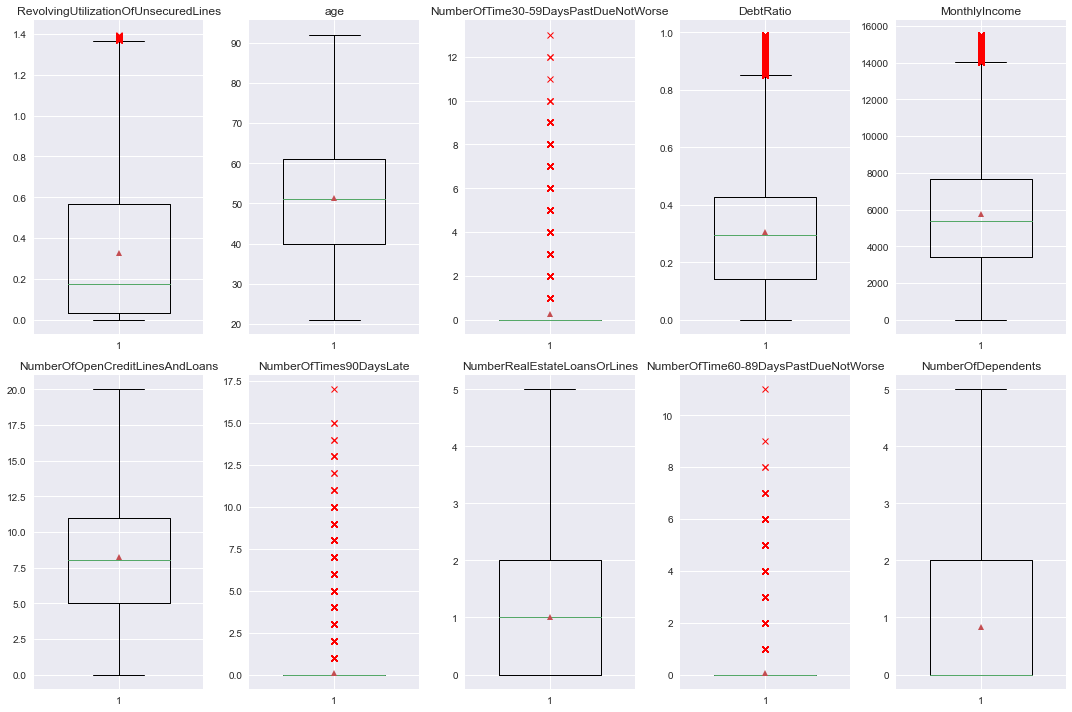

In [10]:
index = data.columns
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.boxplot(data[index[i]], sym='rx', widths=0.6, showmeans=True)
    ax.set_title(index[i])
fig.tight_layout()

### 可见异常值得到了有效的清理

### 分析数据

In [11]:
data.head(10)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.766127,45,2,0.802982,9120.0,13,0,1,0,2.0,1
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,0.907239,49,1,0.024926,5400.0,7,0,1,0,0.0,0
5,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,0
7,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0,0
9,0.189169,57,0,0.606291,5400.0,9,0,4,0,2.0,0
10,0.644226,30,0,0.309476,2500.0,5,0,0,0,0.0,0
11,0.018798,51,0,0.531529,6501.0,7,0,2,0,2.0,0


### 绘制分布区间直方图,了解数据分布情况

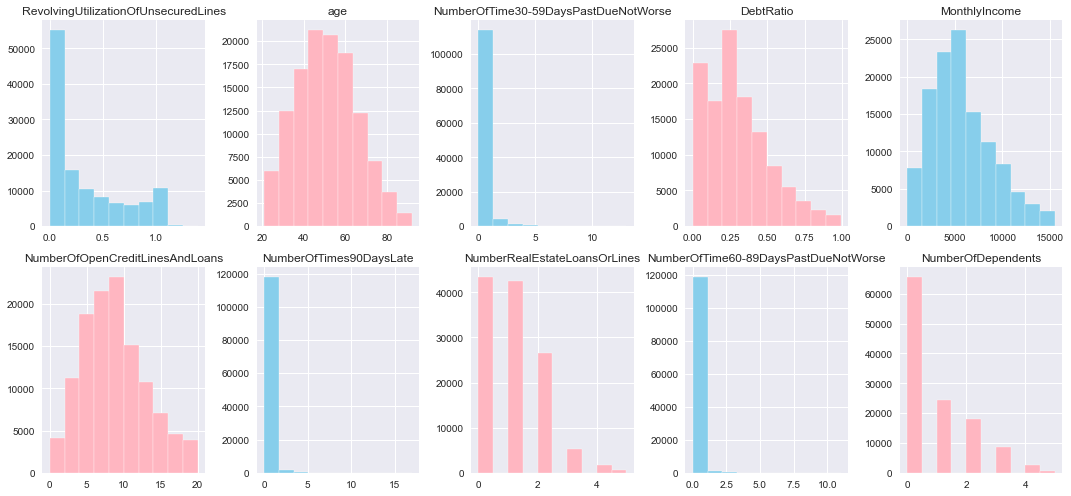

In [12]:
index = data.columns
fig = plt.figure(figsize=(15, 7))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    if i % 2 == 0:
        ax.hist(data[index[i]], color='skyblue', edgecolor='white')
    else:
        ax.hist(data[index[i]], color='lightpink', edgecolor='white')
    ax.set_title(index[i])
fig.tight_layout()

#### 可见大部分数据都存在左偏情况

### 查看肯德尔系数

In [13]:
dt_corr = data.corr(method='kendall')
corr = dt_corr['SeriousDlqin2yrs']
corr

D:\anaconda\envs\ml\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


RevolvingUtilizationOfUnsecuredLines    0.188569
age                                    -0.085476
NumberOfTime30-59DaysPastDueNotWorse    0.240941
DebtRatio                               0.037601
MonthlyIncome                          -0.053690
NumberOfOpenCreditLinesAndLoans        -0.031044
NumberOfTimes90DaysLate                 0.323880
NumberRealEstateLoansOrLines           -0.033286
NumberOfTime60-89DaysPastDueNotWorse    0.258290
NumberOfDependents                      0.043102
SeriousDlqin2yrs                        1.000000
Name: SeriousDlqin2yrs, dtype: float64

### 画出热力图

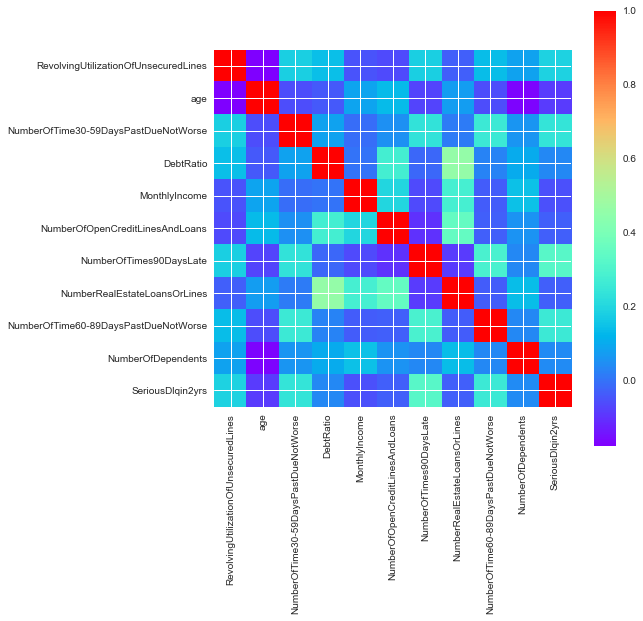

In [14]:
ind = data.columns
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.set_xticks(range(11))
ax.set_yticks(range(11))
ax.set_xticklabels(ind, rotation=90)
ax.set_yticklabels(ind)
map = ax.imshow(dt_corr, cmap='rainbow')
fig.colorbar(map)

### 选择肯德尔系数大于0.1的特征

In [15]:
c = corr[np.abs(corr) > 0.1]
c

RevolvingUtilizationOfUnsecuredLines    0.188569
NumberOfTime30-59DaysPastDueNotWorse    0.240941
NumberOfTimes90DaysLate                 0.323880
NumberOfTime60-89DaysPastDueNotWorse    0.258290
SeriousDlqin2yrs                        1.000000
Name: SeriousDlqin2yrs, dtype: float64

## 训练模型

### 分割数据集为训练集和测试集

In [16]:
dt = data[c.index].copy()
y = dt[['SeriousDlqin2yrs']]
x = dt[c.index].drop(['SeriousDlqin2yrs'], axis=1)
# 随机分割
x_train, y_train, x_test, y_test = train_test_split(x, y, 0.3)

### 选取合适的特征值，并引入测试集

## 此处进行三种处理
- 逻辑回归
- K近邻
- 决策树

# 逻辑回归

In [17]:
# 参数设置
lr = LogisticRegression(alpha=10, cycle=10)

In [18]:
# 数据拟合和预测
lr.fit(x_train, y_train)
lr_pre = lr.predict(x_test)

In [19]:
# 模型评估
lr_a = accuracy(y_test, lr_pre)
lr_f = F1score(y_test, lr_pre)
print('logistic_accuracy:', lr_a)
print('logistic_f1_score:', lr_f)

logistic_accuracy: 0.9324833702882483
logistic_f1_score: 0.2814159292035398


### 画出pr曲线和roc曲线

[Text(0.5, 1.0, 'ROC curve'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

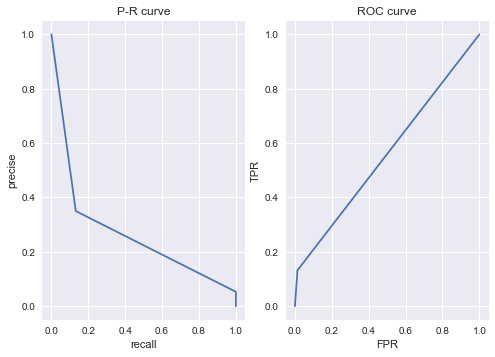

In [20]:
# 图可能画的有点问题
precise1, recall1 = PR(y_test[:1000], lr_pre[:1000])
FPR1, TPR1 = ROC(y_test[:1000], lr_pre[:1000])
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(recall1, precise1)
ax.set(title='P-R curve', xlabel='recall', ylabel='precise')
ax = fig.add_subplot(1, 2, 2)
ax.plot(FPR1, TPR1)
ax.set(title='ROC curve', xlabel='FPR', ylabel='TPR')

In [21]:
# 十次交叉验证
cross_validation(x_train, y_train, lr, accuracy, k=10)

0.9345283179570538

### sklearn对比

In [22]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve

In [23]:
# 训练模型
sk_lr = linear_model.LogisticRegression()
sk_lr.fit(x_train, np.squeeze(y_train))
sk_pre = sk_lr.predict(x_test)

In [24]:
# sklearn模型评估
sk_a = accuracy_score(y_test, sk_pre)
sk_f = f1_score(y_test, sk_pre)
print('logistic_accuracy:', sk_a)
print('logistic_f1_score:', sk_f)

logistic_accuracy: 0.9325110864745011
logistic_f1_score: 0.2411966344655656


[Text(0.5, 1.0, 'ROC curve'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

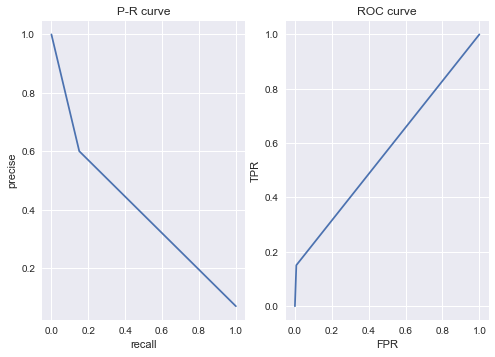

In [25]:
# sklearn的PR曲线和ROC曲线
p1, p2, t1 = precision_recall_curve(y_test, sk_pre)
r1, r2, t2 = roc_curve(y_test, sk_pre)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(p2, p1)
ax.set(title='P-R curve', xlabel='recall', ylabel='precise')
ax = fig.add_subplot(1, 2, 2)
ax.plot(r1, r2)
ax.set(title='ROC curve', xlabel='FPR', ylabel='TPR')

### 可见和sklearn模型评分基本一致

## 检验不同batch size的影响

In [26]:
# 1个一组
l1 = LogisticRegression(alpha=10, cycle=10)
x = np.array(x_train)
y = np.array(y_train)
a = np.split(x, list(range(0, x_train.shape[0], 1)))
b = np.split(y, list(range(0, y_train.shape[0], 1)))
for i in range(len(a)-1):
    if i == 0:
        continue
    l1.fit(a[i], b[i])
p1 = l1.predict(x_test)

D:\MyWork\python\一轮考核-李龙\LogisticRegression\LR.py:61: RuntimeWarning: overflow encountered in exp
  np.dot(self.x.T, (1 / (1 + np.exp(-np.dot(self.x, self.theta))) - self.y))


In [27]:
# 8个一组
l2 = LogisticRegression(alpha=10, cycle=10)
x = np.array(x_train)
y = np.array(y_train)
a = np.split(x, list(range(0, x_train.shape[0], 8)))
b = np.split(y, list(range(0, y_train.shape[0], 8)))
for i in range(len(a)-1):
    if i == 0:
        continue
    l2.fit(a[i], b[i])
p2 = l2.predict(x_test)

In [28]:
# 32个一组
l3 = LogisticRegression(alpha=10, cycle=10)
x = np.array(x_train)
y = np.array(y_train)
a = np.split(x, list(range(0, x_train.shape[0], 32)))
b = np.split(y, list(range(0, y_train.shape[0], 32)))
for i in range(len(a)-1):
    if i == 0:
        continue
    l3.fit(a[i], b[i])
p3 = l3.predict(x_test)

In [29]:
# 64个一组
l4 = LogisticRegression(alpha=10, cycle=10)
x = np.array(x_train)
y = np.array(y_train)
a = np.split(x, list(range(0, x_train.shape[0], 64)))
b = np.split(y, list(range(0, y_train.shape[0], 64)))
for i in range(len(a)-1):
    if i == 0:
        continue
    l4.fit(a[i], b[i])
p4 = l4.predict(x_test)

In [30]:
# 256个一组
l5 = LogisticRegression(alpha=10, cycle=10)
x = np.array(x_train)
y = np.array(y_train)
a = np.split(x, list(range(0, x_train.shape[0], 256)))
b = np.split(y, list(range(0, y_train.shape[0], 256)))
for i in range(len(a)-1):
    if i == 0:
        continue
    l5.fit(a[i], b[i])
p5 = l5.predict(x_test)

In [31]:
# 1024个一组
l6 = LogisticRegression(alpha=10, cycle=10)
x = np.array(x_train)
y = np.array(y_train)
a = np.split(x, list(range(0, x_train.shape[0], 1024)))
b = np.split(y, list(range(0, y_train.shape[0], 1024)))
for i in range(len(a)-1):
    if i == 0:
        continue
    l6.fit(a[i], b[i])
p6 = l6.predict(x_test)

### 以下是相同学习率下的结果

In [32]:
sco1 = accuracy(y_test, p1)
sco2 = accuracy(y_test, p2)
sco3 = accuracy(y_test, p3)
sco4 = accuracy(y_test, p4)
sco5 = accuracy(y_test, p5)
sco6 = accuracy(y_test, p6)
print('size    1:',sco1)
print('size    8:',sco2)
print('size   16:',sco3)
print('size   64:',sco4)
print('size  256:',sco5)
print('size 1024:',sco6)

size    1: 0.9296286031042129
size    8: 0.9289079822616408
size   16: 0.931180709534368
size   64: 0.9306541019955654
size  256: 0.9312361419068736
size 1024: 0.9327050997782705


# 决策树

In [33]:
# 进行数据处理, train和test 为训练集和测试集
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

In [34]:
train.head(10)

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,SeriousDlqin2yrs
0,0.766127,2.0,0.0,0.0,1.0
1,0.658180,1.0,1.0,0.0,0.0
2,0.233810,0.0,0.0,0.0,0.0
3,0.907239,1.0,0.0,0.0,0.0
4,0.213179,0.0,0.0,0.0,0.0
5,0.754464,0.0,0.0,0.0,0.0
6,0.189169,0.0,0.0,0.0,0.0
7,0.644226,0.0,0.0,0.0,0.0
8,0.018798,0.0,0.0,0.0,0.0
9,0.010352,0.0,0.0,0.0,0.0


### 接下来对连续性数据进行离散化处理，顺便剪枝

In [35]:
# 观察数据
print(train['RevolvingUtilizationOfUnsecuredLines'].describe())
print(test['RevolvingUtilizationOfUnsecuredLines'].describe())

count    84189.000000
mean         0.326797
std          0.346810
min          0.000000
25%          0.035472
50%          0.177272
75%          0.564290
max          1.391015
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
count    36080.000000
mean         0.329896
std          0.349372
min          0.000000
25%          0.034199
50%          0.177282
75%          0.576880
max          1.395349
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


In [36]:
# 数据离散化处理
train['RevolvingUtilizationOfUnsecuredLines'] = pp.Cut(train['RevolvingUtilizationOfUnsecuredLines'], 
                                                       bins=[-0.1, 0.04, 0.18, 0.58, 100], labels=False)
test['RevolvingUtilizationOfUnsecuredLines'] = pp.Cut(test['RevolvingUtilizationOfUnsecuredLines'], 
                                                      bins=[-0.1, 0.04, 0.18, 0.58, 100], labels=False)

In [37]:
# 观察数据
print(train['NumberOfTime30-59DaysPastDueNotWorse'].value_counts())
print(test['NumberOfTime30-59DaysPastDueNotWorse'].value_counts())

0.0     70180
1.0      9360
2.0      2795
3.0      1060
4.0       435
5.0       200
6.0        91
7.0        37
8.0        16
9.0         9
12.0        2
10.0        2
11.0        1
13.0        1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64
0.0     29938
1.0      4178
2.0      1162
3.0       465
4.0       200
5.0        84
6.0        33
7.0        11
8.0         7
9.0         1
10.0        1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64


In [38]:
# 数据离散化处理
train['NumberOfTime30-59DaysPastDueNotWorse'] = pp.Cut(train['NumberOfTime30-59DaysPastDueNotWorse'], bins=[-0.1, 1, 6, 100], labels=False)
test['NumberOfTime30-59DaysPastDueNotWorse'] = pp.Cut(test['NumberOfTime30-59DaysPastDueNotWorse'], bins=[-0.1, 1, 6, 100], labels=False)

In [39]:
# 观察数据
print(train['NumberOfTimes90DaysLate'].value_counts())
print(test['NumberOfTimes90DaysLate'].value_counts())

0.0     79591
1.0      3029
2.0       864
3.0       374
4.0       162
5.0        70
6.0        40
7.0        20
8.0        11
9.0        10
10.0        8
13.0        3
11.0        2
12.0        2
15.0        1
14.0        1
17.0        1
Name: NumberOfTimes90DaysLate, dtype: int64
0.0     34101
1.0      1283
2.0       370
3.0       169
4.0        79
5.0        33
6.0        22
7.0         9
8.0         5
9.0         4
11.0        2
15.0        1
14.0        1
13.0        1
Name: NumberOfTimes90DaysLate, dtype: int64


In [40]:
# 数据离散化处理
train['NumberOfTimes90DaysLate'] = pp.Cut(train['NumberOfTimes90DaysLate'], bins=[-0.1, 1, 8, 100], labels=False)
test['NumberOfTimes90DaysLate'] = pp.Cut(test['NumberOfTimes90DaysLate'], bins=[-0.1, 1, 8, 100], labels=False)

In [41]:
# 观察数据
print(train['NumberOfTime60-89DaysPastDueNotWorse'].value_counts())
print(test['NumberOfTime60-89DaysPastDueNotWorse'].value_counts())

0.0     79935
1.0      3353
2.0       622
3.0       175
4.0        65
5.0        20
6.0        12
7.0         4
8.0         1
11.0        1
9.0         1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64
0.0    34207
1.0     1454
2.0      290
3.0       93
4.0       20
5.0        9
6.0        4
7.0        2
8.0        1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64


In [42]:
# 数据离散化处理
train['NumberOfTime60-89DaysPastDueNotWorse'] = pp.Cut(train['NumberOfTime60-89DaysPastDueNotWorse'], bins=[-0.1, 1, 4, 100], labels=False)
test['NumberOfTime60-89DaysPastDueNotWorse'] = pp.Cut(test['NumberOfTime60-89DaysPastDueNotWorse'], bins=[-0.1, 1, 4, 100], labels=False)

### 再次查看数据

In [43]:
train.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,SeriousDlqin2yrs
0,3,1,0,0,1.0
1,3,0,0,0,0.0
2,2,0,0,0,0.0
3,3,0,0,0,0.0
4,2,0,0,0,0.0


In [44]:
test.head()

,RevolvingUtilizationOfUnsecuredLines,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,SeriousDlqin2yrs
0,2,0,0,0,0.0
1,1,0,0,0,0.0
2,3,0,0,0,0.0
3,0,0,0,0,0.0
4,2,1,0,0,0.0


### 决策树（递归生成树，运行有点慢）

In [45]:
# 模型引入
tree1 = DecisionTree(mode='ID3')
tree2 = DecisionTree(mode='C4.5')
tree3 = DecisionTree(mode='CART')

In [46]:
tree1.fit(train)
tree2.fit(train)
tree3.fit(train)

D:\MyWork\python\一轮考核-李龙\DecisionTree\classfication.py:84: RuntimeWarning: invalid value encountered in double_scalars
  gain_list.append((old_ent - new_ent) / _R)
D:\MyWork\python\一轮考核-李龙\DecisionTree\classfication.py:84: RuntimeWarning: invalid value encountered in double_scalars
  gain_list.append((old_ent - new_ent) / _R)
D:\MyWork\python\一轮考核-李龙\DecisionTree\classfication.py:84: RuntimeWarning: invalid value encountered in double_scalars
  gain_list.append((old_ent - new_ent) / _R)
D:\MyWork\python\一轮考核-李龙\DecisionTree\classfication.py:84: RuntimeWarning: invalid value encountered in double_scalars
  gain_list.append((old_ent - new_ent) / _R)
D:\MyWork\python\一轮考核-李龙\DecisionTree\classfication.py:84: RuntimeWarning: invalid value encountered in double_scalars
  gain_list.append((old_ent - new_ent) / _R)
D:\MyWork\python\一轮考核-李龙\DecisionTree\classfication.py:84: RuntimeWarning: invalid value encountered in double_scalars
  gain_list.append((old_ent - new_ent) / _R)
D:\MyWork\python

#### 此处C4.5有runningtime超时警告

In [47]:
pre1 = []
for i in range(test.shape[0]):
    pre1.append(tree1.predict(test.iloc[i]))
pre1 = np.array([pre1]).T

In [48]:
pre2 = []
for i in range(test.shape[0]):
    pre2.append(tree2.predict(test.iloc[i]))
pre2 = np.array([pre2]).T

In [49]:
pre3 = []
for i in range(test.shape[0]):
    pre3.append(tree3.predict(test.iloc[i]))
pre3 = np.array([pre3]).T

In [50]:
#准确性评分
r1 = accuracy(y_test, pre1)
r2 = accuracy(y_test, pre2)
r3 = accuracy(y_test, pre3)
print('ID3  accuracy:', r1)
print('C4.5 accuracy:', r2)
print('CART accuracy:', r3)

ID3  accuracy: 0.9289079822616408
C4.5 accuracy: 0.9289079822616408
CART accuracy: 0.9289079822616408


[Text(0.5, 1.0, 'ROC curve'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

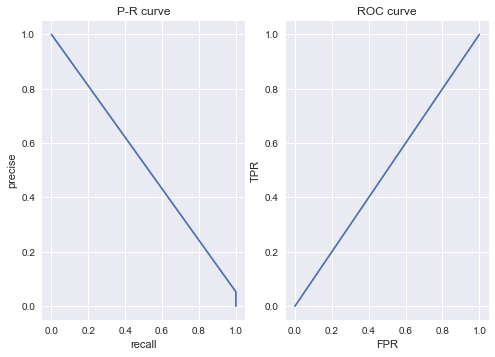

In [51]:
precise1, recall1 = PR(y_test[:1000], pre1[:1000])
FPR1, TPR1 = ROC(y_test[:1000], pre1[:1000])
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(recall1, precise1)
ax.set(title='P-R curve', xlabel='recall', ylabel='precise')
ax = fig.add_subplot(1, 2, 2)
ax.plot(FPR1, TPR1)
ax.set(title='ROC curve', xlabel='FPR', ylabel='TPR')

#### 根据ROC曲线，这个决策树，跟瞎蒙没有什么区别

### sklearn对比

In [52]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
tree = DecisionTreeClassifier()
tree.fit(train.iloc[:, :-1], train.iloc[:, -1])
tree_pre = tree.predict(test.iloc[:, :-1])

In [54]:
# sklearn模型评估
sk_a = accuracy_score(y_test, tree_pre)
sk_f = f1_score(y_test, tree_pre)
print('logistic_accuracy:', sk_a)
print('logistic_f1_score:', sk_f)

logistic_accuracy: 0.9307926829268293
logistic_f1_score: 0.1617992614971467


[Text(0.5, 1.0, 'ROC curve'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

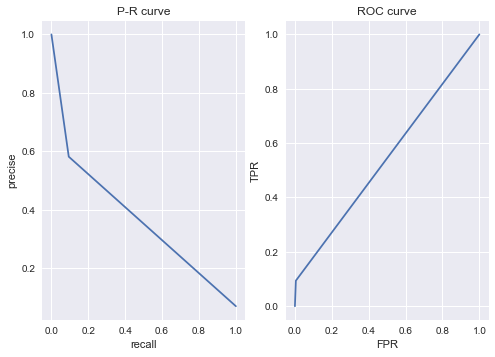

In [55]:
# sklearn的PR曲线和ROC曲线
p1, p2, t1 = precision_recall_curve(y_test, tree_pre)
r1, r2, t2 = roc_curve(y_test, tree_pre)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(p2, p1)
ax.set(title='P-R curve', xlabel='recall', ylabel='precise')
ax = fig.add_subplot(1, 2, 2)
ax.plot(r1, r2)
ax.set(title='ROC curve', xlabel='FPR', ylabel='TPR')

### 可见逻辑回归效果要比决策树好

# K近邻
- 由于总是出现内存不足的memory error，所以更改原始数据的比例(减少50000为0的数据)

In [56]:
# 查看比例
train = pd.concat([x_train, y_train], axis=1)
print('1:', (train.iloc[:, -1] == 1).sum())
print('0:', (train.iloc[:, -1] == 0).sum())

1: 5792
0: 78397


In [57]:
rand = np.random.choice((train.iloc[:, -1] == 0).sum(), size=50000, replace=False)
copy = train.iloc[:, -1].copy()
index = copy[copy == 0].index
del_ind = index[rand]
new_train = train.drop(del_ind)

In [58]:
newy_train = new_train.iloc[:, [-1]]
newx_train = new_train.drop(['SeriousDlqin2yrs'], axis=1)

In [59]:
# 查看比例
print('1:', (new_train.iloc[:, -1] == 1).sum())
print('0:', (new_train.iloc[:, -1] == 0).sum())

1: 5792
0: 28397


In [60]:
k1 = KNN()
k2 = KNN(p=1)
k1.fit(newx_train, newy_train)
k2.fit(newx_train, newy_train)
pre1 = k1.predict(x_test.iloc[:5000])
pre2 = k2.predict(x_test.iloc[:5000])

### 但因为训练集少了，最后结果也不够准确

In [61]:
y_test = np.array(y_test)
print('欧式距离：', accuracy(y_test[:5000], pre1))
print('曼哈顿距离：', accuracy(y_test[:5000], pre2))

欧式距离： 0.9256
曼哈顿距离： 0.9264


[Text(0.5, 1.0, 'ROC curve'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

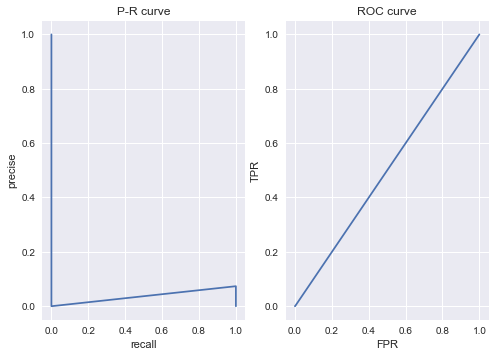

In [62]:
precise1, recall1 = PR(y_test[:5000], pre1)
FPR1, TPR1 = ROC(y_test[:5000], pre1)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(recall1, precise1)
ax.set(title='P-R curve', xlabel='recall', ylabel='precise')
ax = fig.add_subplot(1, 2, 2)
ax.plot(FPR1, TPR1)
ax.set(title='ROC curve', xlabel='FPR', ylabel='TPR')

### 可见knn对于这份数据拟合效果不好

### sklearn对比

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
k = KNeighborsClassifier()
k.fit(x_train, np.squeeze(y_train))
k_pre = k.predict(x_test)

In [65]:
# sklearn模型评估
k_a = accuracy_score(y_test, k_pre)
k_f = f1_score(y_test, k_pre)
print('logistic_accuracy:', k_a)
print('logistic_f1_score:', k_f)

logistic_accuracy: 0.9283536585365854
logistic_f1_score: 0.2654163114521171


[Text(0.5, 1.0, 'ROC curve'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

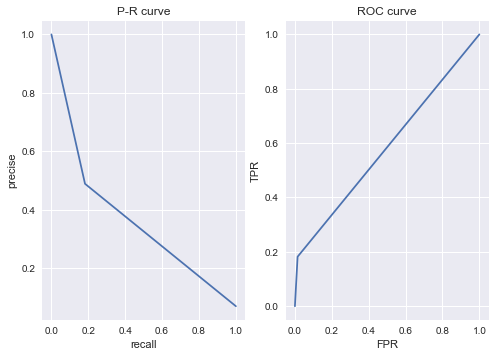

In [66]:
# sklearn的PR曲线和ROC曲线
p1, p2, t1 = precision_recall_curve(y_test, k_pre)
r1, r2, t2 = roc_curve(y_test, k_pre)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.plot(p2, p1)
ax.set(title='P-R curve', xlabel='recall', ylabel='precise')
ax = fig.add_subplot(1, 2, 2)
ax.plot(r1, r2)
ax.set(title='ROC curve', xlabel='FPR', ylabel='TPR')

In [67]:
# 全选0的准确率
accuracy(y_test, np.zeros(y_test.shape[0]))

0.9289079822616408

### 可见knn确实不适合拟合这个数据